## Defining th dataset

In [706]:
# !pip install datasets==1.18.1
#the script is given by iitb to their direct repository to download the dataset
from datasets import load_dataset

In [707]:
#majorly the dataset for hindi to english traslation comes from
#https://www.cfilt.iitb.ac.in/iitb_parallel/ 
#let us explore the data set and build corpus for both


dataset = load_dataset("cfilt/iitb-english-hindi")

Using custom data configuration cfilt--iitb-english-hindi-2cfae92395f2614b
Reusing dataset parquet (/home/jupyter-st125490/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-2cfae92395f2614b/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [708]:
#lets explore the dataset before we beigin building corpus
import torch
for i in range(5):
    print(dataset['train'][i])

{'translation': {'en': 'Give your application an accessibility workout', 'hi': 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें'}}
{'translation': {'en': 'Accerciser Accessibility Explorer', 'hi': 'एक्सेर्साइसर पहुंचनीयता अन्वेषक'}}
{'translation': {'en': 'The default plugin layout for the bottom panel', 'hi': 'निचले पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'The default plugin layout for the top panel', 'hi': 'ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका'}}
{'translation': {'en': 'A list of plugins that are disabled by default', 'hi': 'उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है'}}


In [4]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device, torch.cuda.get_device_name(0))

cuda:1 NVIDIA GeForce RTX 2080 Ti


**As we can see the dataset have 1659083 number of rows this one of the biggest dataset used in language translation and model from english to hindi, if in case 
we are not able to use the whole dataset we will take random examples**

In [709]:
#let us create a dataset loader for random 5000 sampling for our training dataset since we have limited resources 
# !git clone https://github.com/libindic/indicstemmer.git
# !cd indicstemmer
# !python3 setup.py sdist
# !pip install /home/jupyter-st125490/indicstemmer/dist/libindic_stemmer-0.1.1.dev130.tar.gz
from torch.utils.data import DataLoader, RandomSampler, Subset
import re
import nltk
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from libindic.stemmer import Stemmer
from indic_transliteration import sanscript
from indic_transliteration.sanscript import SchemeMap, SCHEMES
from indic_transliteration.sanscript.schemes import Scheme
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI
from nltk.corpus import stopwords
from tqdm import tqdm
batch_size=32

subset=Subset(dataset['train'] , list(range(1000)))
data_loader = DataLoader(subset ,batch_size, shuffle=False)


**For hindi language we are inidc-stemer as is is based on the rules based system  iterative suffix stripping to handle multiple levels of inflection**

In [712]:
# nitialize Hindi stemmer
#from libindic.stemmer import Hindi

# hindi_stemmer = Hindi.Hindi()

# # Initialize English stemmer
# english_stemmer = PorterStemmer()

def remove_numbers(text):
    # Remove English numbers
    text = re.sub(r'\d+', '', text)
        # Remove Hindi numbers
    hindi_numbers = ['०', '१', '२', '३', '४', '५', '६', '७', '८', '९']
    for num in hindi_numbers:
        text = text.replace(num, '')
    
    return text

def remove_english_letters(text):
    # Remove English letters
    text = re.sub(r'[a-zA-Z]', '', text)
    
    return text

def hindi_punc(text):
    # Remove spaces and special characters
    text = re.sub(r'[^\w\s\u0900-\u097F॥।]', ' ', text)
    
    return text

# Define function to clean and preprocess text
def clean_and_preprocess_text(text, language):
    # Remove punctuation
    if language == 'english':
        text = re.sub(r'[^\w\s]', '', text)
    text = remove_numbers(text)
    # Tokenize text
    if language == 'hindi':
        text = hindi_punc(text)
        text = remove_english_letters(text)
    tokens = word_tokenize(text)
    # Remove stopwords
    if language == 'hindi':
        stop_w = set(STOP_WORDS_HI)
        tokens = [token.casefold() for token in tokens if token not in stop_w]
    elif language == 'english':
        stop_w = set(stopwords.words('english'))
        tokens = [token.lower() for token in tokens if token not in stop_w]

   
    #although stemming is a good idea but we stop using it as language translator need semantic meaning
    # # Stem tokens
    # if language == 'hindi':
    #     tokens = [hindi_stemmer.stem(token) for token in tokens]
    #     values = [list(d.values()) for d in tokens]
    #     tokens = [item for sublist in values for item in sublist]

    # elif language == 'english':
    #     tokens = [english_stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    text = ' '.join(tokens)

    return tokens

def preprocess_batch(batch):
    hindi_texts = batch['translation']['hi']
    english_texts = batch['translation']['en']

    preporcessing_hindi_text = []
    preporcessing_english_text = []

    for hindi_text, english_text in zip(hindi_texts, english_texts):
        _hi_text = clean_and_preprocess_text(hindi_text, 'hindi')
        _en_text = clean_and_preprocess_text(english_text, 'english')

        preporcessing_hindi_text.append(_hi_text)
        preporcessing_english_text.append(_en_text)
    return preporcessing_hindi_text, preporcessing_english_text

In [711]:
for batch in data_loader:
    print(preprocess_batch(batch))
    break

([['अनुप्रयोग', 'पहुंचनीयता', 'व्यायाम', 'लाभ', 'दें'], ['एक्सेर्साइसर', 'पहुंचनीयता', 'अन्वेषक'], ['निचले', 'पटल', 'डिफोल्ट', 'प्लग', 'खाका'], ['ऊपरी', 'पटल', 'डिफोल्ट', 'प्लग', 'खाका'], ['प्लग', 'इनों', 'सूची', 'डिफोल्ट', 'रूप', 'निष्क्रिय'], ['अवधि', 'हाइलाइट', 'रकें'], ['पहुंचनीय', 'आसंधि', 'नोड', 'चुनते', 'समय', 'हाइलाइट', 'बक्से', 'अवधि'], ['सीमांत', 'बोर्डर', 'रंग', 'हाइलाइट'], ['हाइलाइट', 'किए', 'गए', 'सीमांत', 'रंग', 'अपारदर्शिता।'], ['भराई', 'रंग', 'हाइलाइट'], ['हाइलाइट', 'भराई', 'रंग', 'पारदर्शिता।'], ['एपीआई', 'विचरक'], ['समय', 'प्राप्त', 'उसकी', 'विभिन्न', 'विधियों', 'मेथड', 'विचरण'], ['निजी', 'गुणों', 'छिपाएं'], ['विधि'], ['गुणधर्म'], ['मान'], ['आईपाइथन', 'कन्सोल'], ['समय', 'चुने', 'गए', 'एक्सेसेबेल', 'काम', 'लेने', 'अंतर्क्रियात्मक', 'कन्सोल'], ['घटना', 'मानिटर'], ['घटनाओं', 'मानिटर', '_'], ['चुनाव', 'हटाएं', '_'], [], ['चुने', 'गए', 'अनुप्रयोग'], ['चुने', 'गए', 'एक्सेसेबेल'], ['स्रोत'], ['घटना', 'मानिटर'], ['चुने', 'गए', 'प्रकारों', 'स्रोतों', 'घटनाएं', 'घटित', 'दर्शाता

In [713]:
from collections import defaultdict
from torch.utils.data import DataLoader

# Special tokens
unk_token = '<unk>'
pad_token = '<pad>'
eos_token = '<EOS>'

# Function to create vocabulary
def create_vocab(data_loader):
    # Initialize vocabularies for both source and target languages
    vocab = {
        'src': {unk_token: 0, pad_token: 1, eos_token: 2},
        'tar': {unk_token: 0, pad_token: 1, eos_token: 2}
    }
    index_src = 3  # Start indexing from 3 (after <unk>, <pad>, <EOS>)
    index_tar = 3  # Start for target language

    # Iterate over the data loader
    for batch in data_loader:
        src, tar = preprocess_batch(batch)  # Assuming this returns tokenized src and tar sentences
        
        # Process source language tokens
        for sentence in src:
            for word in sentence:
                if word not in vocab['tar']:
                    vocab['tar'][word] = index_src
                    index_src += 1

        # Process target language tokens
        for sentence in tar:
            for word in sentence:
                if word not in vocab['src']:
                    vocab['src'][word] = index_tar
                    index_tar += 1

    return vocab

# Example usage of the create_vocab function
# Assuming `dataset` is a custom dataset that has been preprocessed
# data_loader = DataLoader(dataset, batch_size=32, num_workers=4)

# Create vocabularies for source and target languages
vocab = create_vocab(data_loader)


In [10]:
# vocab['tar']['विस्तार']

In [11]:
# vocab['src'].get("call", vocab['src']['<unk>'])

## Prepeare data for Traning

In [893]:
 # Define maximum sequence length (can be adjusted or computed dynamically)
max_len = 7

# Lists to hold the padded input IDs and attention masks
input_ids_src = []
attention_masks_src = []
input_ids_tar = []
attention_masks_tar = []

for batch in data_loader:
    # Extract the source (English) and target (Hindi) text from the batch
    hi_text, en_text = preprocess_batch(batch)
    # Process the source (English) text
    for text in en_text:
        # Tokenize the text (convert words to indices using vocab_en)
        tokens = [vocab['src'].get(word, vocab['src']['<unk>']) for word in text]
        
        # Pad the tokens to max_len
        padded_tokens = tokens[:max_len] + [vocab['src']['<pad>']] * (max_len - len(tokens))
        
        # Create the attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1 if token != vocab['src']['<pad>'] else 0 for token in padded_tokens]
        
        # Append the padded tokens and attention mask to the lists
        input_ids_src.append(padded_tokens)
        attention_masks_src.append(attention_mask)

    # Process the target (Hindi) text
    for text in hi_text:
        # Tokenize the text (convert words to indices using vocab_hi)
        tokens = [vocab['tar'].get(word, vocab['tar']['<unk>']) for word in text]
        
        # Pad the tokens to max_len
        padded_tokens = tokens[:max_len] + [vocab['tar']['<pad>']] * (max_len - len(tokens))
        
        # Create the attention mask (1 for real tokens, 0 for padding)
        attention_mask = [1 if token != vocab['tar']['<pad>'] else 0 for token in padded_tokens]
        
        # Append the padded tokens and attention mask to the lists
        input_ids_tar.append(padded_tokens)
        attention_masks_tar.append(attention_mask)

# Convert the lists to tensors
input_ids_src = torch.tensor(input_ids_src)
attention_masks_src = torch.tensor(attention_masks_src)
input_ids_tar = torch.tensor(input_ids_tar)
attention_masks_tar = torch.tensor(attention_masks_tar)

# Output the shapes for verification
print("Source input IDs shape:", input_ids_src.shape)
print("Source attention masks shape:", attention_masks_src.shape)
print("Target input IDs shape:", input_ids_tar.shape)
print("Target attention masks shape:", attention_masks_tar.shape)


Source input IDs shape: torch.Size([1000, 7])
Source attention masks shape: torch.Size([1000, 7])
Target input IDs shape: torch.Size([1000, 7])
Target attention masks shape: torch.Size([1000, 7])


In [57]:
np.save('vocab_attention', vocab)
np.save('input_src', input_ids_src)
np.save('input_tar', input_ids_tar)

## Defining models Addition Model

In [1158]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device, additive):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device  = device
        self.additive = additive
    def create_mask(self, src):
        #src: [src len, batch_size]
        mask = torch.isin(src, torch.tensor(self.src_pad_idx))
        mask = mask.permute(1, 0)  #permute so that it's the same shape as attention
        #mask: [batch_size, src len] #(0, 0, 0, 0, 0, 1, 1)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0):
        #src: [src len, batch_size]
        #trg: [trg len, batch_size]
        
        #initialize something
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs    = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #send our src text into encoder
        encoder_outputs, hidden = self.encoder(src)
        #encoder_outputs refer to all hidden states (last layer)
        #hidden refer to the last hidden state (of each layer, of each direction)
        
        input_ = trg[0, :]
        
        mask   = self.create_mask(src) #(0, 0, 0, 0, 0, 1, 1)
        
        #for each of the input of the trg text
        for t in range(1, trg_len):
            #send them to the decoder
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output: [batch_size, output_dim] ==> predictions
            #hidden: [batch_size, hid_dim]
            #attention: [batch_size, src len]
            
            #append the output to a list
            outputs[t] = output
            attentions[t] = attention
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1          = output.argmax(1)  #autoregressive
            
            input_ = trg[t] if teacher_force else top1
            
        return outputs, attentions


In [1159]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Embedding the input sequence
        embedded = self.dropout(self.embedding(src))  # [src_len, batch_size, emb_dim]

        # Pass the embedded sequence through the GRU
        outputs, hidden = self.rnn(embedded)  # [src_len, batch_size, hid_dim * 2]

        # We concatenate the last hidden states from both forward and backward directions
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))  # [batch_size, hid_dim]

        return outputs, hidden




In [1160]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim, hid_dim) #for decoder input_
        self.U = nn.Linear(hid_dim * 2, hid_dim)  #for encoder_outputs

    
    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch_size, hid_dim] ==> first hidden is basically the last hidden of the encoder
        #encoder_outputs = [src len, batch_size, hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len    = encoder_outputs.shape[0]
        
        #repeat the hidden src len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch_size, src_len, hid_dim]
        
        #permute the encoder_outputs just so that you can perform multiplication / addition
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch_size, src_len, hid_dim * 2]
        
        #add
        energy = self.v(torch.tanh(self.W(hidden) + self.U(encoder_outputs))).squeeze(2)
        #(batch_size, src len, 1) ==> (batch_size, src len)
        
        #mask
        energy = energy.masked_fill(mask, -1e10)
        
        return torch.nn.functional.softmax(energy, dim = 1)


In [1161]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention  = attention
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn        = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc         = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        # input: [batch_size]
        # hidden: [batch_size, hid_dim]
        # encoder_outputs: [src_len, batch_size, hid_dim * 2]
        # mask: [batch_size, src_len] (mask for padded tokens)
        
        # Embed our input
        input = input.unsqueeze(0)  # [1, batch_size]
        embedded = self.dropout(self.embedding(input))  # [1, batch_size, emb_dim]
        
        # Apply attention mechanism, considering padding
        a = self.attention(hidden, encoder_outputs, mask)  # Attention weights: [batch_size, src_len]
        att = a.unsqueeze(1)  # [batch_size, 1, src_len]
        
        # Permute encoder outputs to [batch_size, src_len, hid_dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_len, hid_dim * 2]
        
        # Calculate weighted sum of encoder outputs based on attention weights
        weighted = torch.bmm(att, encoder_outputs)  # [batch_size, 1, hid_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # [1, batch_size, hid_dim * 2]
        
        # Concatenate embedded input and weighted encoder outputs
        rnn_input = torch.cat((embedded, weighted), dim=2)  # [1, batch_size, emb_dim + hid_dim * 2]
        
        # Send input to the GRU
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))  # [1, batch_size, hid_dim]
        
        # Squeeze the outputs from the GRU and weighted sum
        embedded = embedded.squeeze(0)  # [batch_size, emb_dim]
        output = output.squeeze(0)  # [batch_size, hid_dim]
        weighted = weighted.squeeze(0)  # [batch_size, hid_dim * 2]
        
        # Apply the fully connected layer to predict the next token
        prediction = self.fc(torch.cat((embedded, output, weighted), dim=1))  # [batch_size, output_dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)


In [1038]:
# class Decoder(nn.Module):
#     def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
#         super().__init__()
#         self.output_dim = output_dim
#         self.attention = attention  # The attention mechanism
#         self.embedding = nn.Embedding(output_dim, emb_dim)
#         self.rnn = nn.GRU(1280, hid_dim)  # GRU expects input size of 1280
#         self.fc = nn.Linear(3 * hid_dim * 2, output_dim)  # Adjusted fc layer size
#         self.dropout = nn.Dropout(dropout)
        
#         # Linear layer to project `embedding` to match the feature size of `weighted`
#         self.embedding_projection = nn.Linear(emb_dim, hid_dim * 2)  # Project embedded to hid_dim * 2
        
#         # Linear layer to match the expected input size for the GRU
#         self.input_projection = nn.Linear((hid_dim * 2) + (hid_dim * 2), 1280)  # Adjust the input size to 1280
        
#         # Additional Linear layer to project `output` to the same size as `embedded` and `weighted`
#         self.output_projection = nn.Linear(hid_dim, hid_dim * 2)  # Project output to hid_dim * 2

#     def forward(self, input, hidden, encoder_outputs):
#         # input: [batch_size]
#         # hidden: [batch_size, hid_dim]
#         # encoder_outputs: [src_len, batch_size, hid_dim * 2]
#         # mask: [batch_size, src_len]  (for padded tokens)
        
#         input = input.unsqueeze(0)  # Shape: [1, batch_size]
#         embedded = self.dropout(self.embedding(input))  # Shape: [1, batch_size, emb_dim]
        
#         # Project the embedded input to match the size of weighted (hid_dim * 2)
#         embedded = self.embedding_projection(embedded)  # Shape: [1, batch_size, hid_dim * 2]
        
#         # Calculate the attention weights using the attention mechanism (Multiplicative or Additive)
    
#         a = self.attention(hidden, encoder_outputs)  # For additive attention
        
#         a = a.unsqueeze(1)  # Shape: [batch_size, 1, src_len]
#         # Permute encoder_outputs to [batch_size, src_len, hid_dim * 2]
#         encoder_outputs = encoder_outputs.permute(1, 0, 2)  # Shape: [batch_size, src_len, hid_dim * 2]

#         # Calculate the weighted sum of encoder outputs using attention weights
#         weighted = torch.bmm(a, encoder_outputs)  # Shape: [batch_size, 1, hid_dim * 2]
#         weighted = weighted.permute(1, 0, 2)  # Shape: [1, batch_size, hid_dim * 2]
        
#         # Concatenate the projected `embedded` input with the weighted encoder outputs
#         embedded = embedded.expand(weighted.size(0), -1, -1)  # Expand along batch dimension
        
#         rnn_input = torch.cat((embedded, weighted), dim=2)  # Shape: [1, batch_size, hid_dim * 2 + hid_dim * 2]
        
#         # Use the linear layer to match the expected input size for the GRU
#         rnn_input = self.input_projection(rnn_input)  # Shape: [1, batch_size, 1280]
        
#         # Pass through GRU (decoder RNN)
#         output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))  # Shape: [1, batch_size, hid_dim]
        
#         # Project the `output` to match the size of `embedded` and `weighted` (hid_dim * 2)
#         output = self.output_projection(output)  # Shape: [batch_size, hid_dim * 2]
        
#         # Check the shapes of tensors before concatenation
#         # print("Embedded shape:", embedded.shape)  # [batch_size, hid_dim * 2]
#         # print("Output shape:", output.shape)  # [batch_size, hid_dim * 2]
#         # print("Weighted shape:", weighted.shape)  # [batch_size, hid_dim * 2]
        
#         # Output from GRU should be passed to fully connected layer
#         embedded = embedded.squeeze(0)  # Shape: [batch_size, hid_dim * 2]
#         output = output.squeeze(0)  # Shape: [batch_size, hid_dim * 2]
#         weighted = weighted.squeeze(0)  # Shape: [batch_size, hid_dim * 2]
        
#         # Final prediction (output)
#         prediction = self.fc(torch.cat((embedded, output, weighted), dim=1))  # Shape: [batch_size, output_dim]
        
#         return prediction, hidden.squeeze(0), a.squeeze(1)  # Return the prediction and updated hidden state



In [906]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [1162]:
input_dim   = len(vocab['src'])
output_dim  = len(vocab['tar'])
emb_dim     = 300  
hid_dim     =  540
dropout     = 0.3
SRC_PAD_IDX = [0,1,2]
query_hidden_size = 1200  # Hidden state size
key_hidden_size = 1240    # Key size (same as query size in this case)
batch_size = 32          # Batch size
seq_len = 8
attention = Attention(hid_dim)
enc  = Encoder(input_dim,  emb_dim,  hid_dim,dropout=dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attention)
device = "cpu"
model = Seq2SeqPackedAttention(enc, dec,SRC_PAD_IDX, device, additive=True).to(device)
model


Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(281, 300)
    (rnn): GRU(300, 540, bidirectional=True)
    (fc): Linear(in_features=1080, out_features=540, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=540, out_features=1, bias=False)
      (W): Linear(in_features=540, out_features=540, bias=True)
      (U): Linear(in_features=1080, out_features=540, bias=True)
    )
    (embedding): Embedding(305, 300)
    (rnn): GRU(1380, 540)
    (fc): Linear(in_features=1920, out_features=305, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [1163]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

 84300
486000
874800
  1620
  1620
486000
874800
  1620
  1620
583200
   540
   540
291600
   540
583200
   540
 91500
2235600
874800
  1620
  1620
585600
   305
______
8063585


In [1164]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = 0) #combine softmax with cross entropy


In [1165]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    src_length = 8
    IGNORE_TOKENS = [0, 1, 2]

    for src, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        mask = ~torch.isin(trg, torch.tensor(IGNORE_TOKENS)).bool()

        loss = criterion(output, trg)
        loss.backward()
        
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [1166]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import random

# Define your CustomDataset
class CustomDataset(Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data
    
    def __len__(self):
        return len(self.src_data)
    
    def __getitem__(self, idx):
        src = self.src_data[idx]
        trg = self.trg_data[idx]
        return src, trg

trainloader = CustomDataset(input_ids_src, input_ids_tar)

train_size = int(0.7 * len(trainloader))  # 80% for training
val_size = int(0.2 * len(trainloader))    # 10% for validation
test_size = len(trainloader) - train_size - val_size  # Remaining 10% for testing

indices = list(range(len(trainloader)))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_subset = Subset(trainloader, train_indices)
val_subset = Subset(trainloader, val_indices)
test_subset = Subset(trainloader, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=4)

train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

print(f"Train loader length: {train_loader_length}")
print(f"Validation loader length: {val_loader_length}")
print(f"Test loader length: {test_loader_length}")


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Train loader length: 22
Validation loader length: 7
Test loader length: 4


In [1167]:
import gc
def evaluate(model, loader, criterion, loader_length, model_type):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    src_len = 7
    epoch_loss = 0
    IGNORE_TOKENS = [0, 1, 2]

    with torch.no_grad():
    
        for src, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)
            if model_type == "additive":
                output, attentions = model(src,seq_len, trg, 0) #turn off teacher forcing
            elif model_type == "mul":
                output, attentions =model(src, trg, 0) 

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            mask = ~torch.isin(trg, torch.tensor(IGNORE_TOKENS)).bool()
            
            loss = criterion(output, trg)
            # loss = loss * mask.float()
            # loss = loss.sum() / mask.sum()
            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim            
            epoch_loss += loss
            gc.collect()

        
    return epoch_loss / loader_length

In [1069]:
import time
import torch.functional as F 
import random 
import math
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length, model_type='additive')
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    gc.collect()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

 20%|██        | 1/5 [00:39<02:36, 39.00s/it]

Epoch: 01 | Time: 0m 37s
	Train Loss: 2.011 | Train PPL:   7.474
	 Val. Loss: 2.027 |  Val. PPL:   7.593


 40%|████      | 2/5 [01:17<01:56, 38.78s/it]

Epoch: 02 | Time: 0m 37s
	Train Loss: 1.963 | Train PPL:   7.121
	 Val. Loss: 2.073 |  Val. PPL:   7.951


 60%|██████    | 3/5 [01:58<01:19, 39.63s/it]

Epoch: 03 | Time: 0m 39s
	Train Loss: 1.974 | Train PPL:   7.200
	 Val. Loss: 2.028 |  Val. PPL:   7.601


 80%|████████  | 4/5 [02:37<00:39, 39.35s/it]

Epoch: 04 | Time: 0m 38s
	Train Loss: 1.951 | Train PPL:   7.038
	 Val. Loss: 2.042 |  Val. PPL:   7.708


100%|██████████| 5/5 [03:16<00:00, 39.31s/it]

Epoch: 05 | Time: 0m 38s
	Train Loss: 1.974 | Train PPL:   7.198
	 Val. Loss: 2.049 |  Val. PPL:   7.763


**Best Traning Done but i dont know if it was the best split**

In [1168]:
import time
import torch.functional as F 
import random 
import math
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length, model_type='additive')
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    gc.collect()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

 20%|██        | 1/5 [00:38<02:35, 38.79s/it]

Epoch: 01 | Time: 0m 37s
	Train Loss: 2.584 | Train PPL:  13.244
	 Val. Loss: 2.327 |  Val. PPL:  10.244


 40%|████      | 2/5 [01:17<01:56, 38.96s/it]

Epoch: 02 | Time: 0m 38s
	Train Loss: 2.149 | Train PPL:   8.574
	 Val. Loss: 2.218 |  Val. PPL:   9.185


 60%|██████    | 3/5 [01:59<01:20, 40.20s/it]

Epoch: 03 | Time: 0m 40s
	Train Loss: 2.034 | Train PPL:   7.644
	 Val. Loss: 2.204 |  Val. PPL:   9.063


 80%|████████  | 4/5 [02:37<00:39, 39.17s/it]

Epoch: 04 | Time: 0m 36s
	Train Loss: 2.036 | Train PPL:   7.661
	 Val. Loss: 2.174 |  Val. PPL:   8.796


100%|██████████| 5/5 [03:17<00:00, 39.47s/it]

Epoch: 05 | Time: 0m 38s
	Train Loss: 1.962 | Train PPL:   7.114
	 Val. Loss: 2.138 |  Val. PPL:   8.485


In [1070]:
input_ids_src[2]

tensor([ 9, 10, 11, 12, 13, 14,  1])

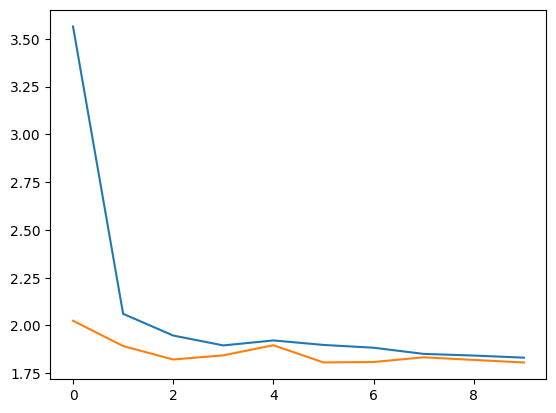

In [245]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(valid_losses)

**The training can go more longer but let us try to infer before we try to decide**

## Inference

In [1176]:
#select random sentences
s = input_ids_src[43,:].unsqueeze(0)
t = input_ids_tar[45,:]
model.eval()  

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(281, 300)
    (rnn): GRU(300, 540, bidirectional=True)
    (fc): Linear(in_features=1080, out_features=540, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=540, out_features=1, bias=False)
      (W): Linear(in_features=540, out_features=540, bias=True)
      (U): Linear(in_features=1080, out_features=540, bias=True)
    )
    (embedding): Embedding(305, 300)
    (rnn): GRU(1380, 540)
    (fc): Linear(in_features=1920, out_features=305, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [1184]:
#x, hidden, cell, encoder_state
IGNORE_TOKENS = [0, 1, 2]
encoder_state ,hidden = model.encoder(s)
mask=model.create_mask(s)
predictions, hidden, attention =model.decoder(t,hidden, encoder_state, mask = mask)

In [1178]:
output = predictions  # Shape: [batch_size, seq_len, vocab_size]
attention_weights = attention
# Assuming vocab_size is 299 (as per your example)
index_to_token_src = {i: token for i, token in enumerate(vocab['src'])}
index_to_token = {i: token for i, token in enumerate(vocab['tar'])}
vocab_size = len(vocab['tar'])
output_probs = torch.softmax(output, dim=-1) 
predicted_tokens = output_probs.argmax(dim=-1)  
predicted_sentence = [index_to_token[token.item()] for token in predicted_tokens]  # For batch_size=1, get the first sentence
input_sentebce=[index_to_token_src[token] for token in s.squeeze(0).tolist()]  # For batch_size=1, get the first sentence
print("Predicted Sentence:", " ".join(predicted_sentence))
print("Input Sentence:"," ".join(input_sentebce))

Predicted Sentence: सापेक्ष स्थिति <pad> <pad> <pad> <pad> <pad>
Input Sentence: relative position <pad> <pad> <pad> <pad> <pad>


In [1170]:
#save the model
# torch.save(model,'model_additive3')
# torch.save(model, 'model_additive_weights3')

output = predictions  # Shape: [batch_size, seq_len, vocab_size]
attention_weights = attention
# Assuming vocab_size is 299 (as per your example)
index_to_token_src = {i: token for i, token in enumerate(vocab['src'])}
index_to_token = {i: token for i, token in enumerate(vocab['tar'])}
vocab_size = len(vocab['tar'])
output_probs = torch.softmax(output, dim=-1) 
predicted_tokens = output_probs.argmax(dim=-1)  
predicted_sentence = [index_to_token[token.item()] for token in predicted_tokens]  # For batch_size=1, get the first sentence
input_sentebce=[index_to_token_src[token] for token in s.squeeze(0).tolist()]  # For batch_size=1, get the first sentence
print("Predicted Sentence:", " ".join(predicted_sentence))
print("Input Sentence:"," ".join(input_sentebce))

Predicted Sentence: ऊपरी <pad> सहेज एकल चुनाव शिशु <pad>
Input Sentence: border color <pad> <pad> <pad> <pad> <pad>


In [1080]:
# model=torch.load('model_additive')
model.eval()
#making inference
output = predictions  # Shape: [batch_size, seq_len, vocab_size]
attention_weights = attention
# Assuming vocab_size is 299 (as per your example)
index_to_token_src = {i: token for i, token in enumerate(vocab['src'])}
index_to_token = {i: token for i, token in enumerate(vocab['tar'])}
vocab_size = len(vocab['tar'])
output_probs = torch.softmax(output, dim=-1) 
predicted_tokens = output_probs.argmax(dim=-1)  
predicted_sentence = [index_to_token[token.item()] for token in predicted_tokens]  # For batch_size=1, get the first sentence
input_sentebce=[index_to_token_src[token] for token in s.squeeze(0).tolist()]  # For batch_size=1, get the first sentence
print("Predicted Sentence:", " ".join(predicted_sentence))
print("Input Sentence:"," ".join(input_sentebce))

Predicted Sentence: सीमांत अवधिः <pad> <pad> <pad> <pad> <pad>
Input Sentence: highlight duration <pad> <pad> <pad> <pad> <pad>


In [1091]:
torch.save(train_loader,'train_loader')

**This amazing after so many runs but unfortunatly i lost the good model**

## Multplicative Encoder Decoder Attention 

In [618]:
class Encoder(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, drop_r):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True, dropout=drop_r)
        self.dropout = nn.Dropout(drop_r)
        self.fc_hidden = nn.Linear(hidden_size*2 , hidden_size)
        self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

    def forward(self,x):
        embedding = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.rnn(embedding)
        encoder_state, (hidden, cell) = self.rnn(embedding)
        hidden_forward = hidden[::2]  # Take every second index (even indices) -> forward hidden states
        hidden_backward = hidden[1::2]
    
        
        hidden = self.fc_hidden(torch.cat((hidden_forward, hidden_backward), dim=2))
        cell = self.fc_cell(torch.cat((cell[::2], cell[1::2]), dim=2))
        return encoder_state ,hidden, cell



In [103]:
# class Decoder(nn.Module):
#     def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers):
#         super(Decoder, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.embedding = nn.Embedding(input_size, embedding_size)
#         self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers)
#         self.energy = nn.Linear(hidden_size*3, 1)
#         self.softmax = nn.Softmax(dim = 0)
#         self.relu = nn.ReLU()
#         self.fc = nn.Linear(hidden_size, output_size)


#     def forward(self, x, hidden, cell, encoder_state):
#         x = x.unsqueeze(0)
#         embedding = self.embedding(x)
#         sequence_length = encoder_state.shape[0]
#         h_reshaped = hidden.repeat(sequence_length, 1, 1)
#         print("h_reshaped", h_reshaped.shape)
#         print("encoder_state", encoder_state.shape)
#         energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_state), dim = 2)))
#         attention = self.softmax(energy)
#         attention = attention.permute(1,2,0)
#         encoder_state = encoder_state.permute(1,0,2)
#         context_vector =torch.bmm(attention, encoder_state).permute(1,0,2)
#         rnn_input = torch.cat((context_vector, embedding), dim= 2)
#         outputs ,(hidden, cell) = self.rnn(rnn_input, (hidden, cell))
#         prediction = self.fc(outputs)
#         predictions = prediction.squeeze(0)
#         return prediction, hidden, cell, attention
        

In [337]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, drop_r):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        # LSTM with num_layers
        self.rnn = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers, dropout=drop_r)
        self.energy = nn.Linear(hidden_size*3, 1)
        self.softmax = nn.Softmax(dim = 0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop_r)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc = nn.Linear(hidden_size * 3, output_size)  # Conca


        self.context_projection = nn.Linear(hidden_size*2, hidden_size)  # Project context_vector to hidden_size
        self.output_projection = nn.Linear(hidden_size, hidden_size) 
        self.embedding_projection = nn.Linear(embedding_size, hidden_size)
        

    def forward(self, x, hidden, cell, encoder_state):
        x = x.unsqueeze(0)  # Add sequence dimension: [1, batch_size]
        embedding = self.dropout(self.embedding(x))  # Shape: [1, batch_size, embedding_size]
        sequence_length = encoder_state.shape[0]  # Sequence length from encoder outputs

        # Repeat hidden state across the sequence length (for attention)
        h_reshaped = hidden.repeat(sequence_length, 1, 1)  # Shape: [seq_len, batch_size, hidden_size]
        
        # Ensure batch_size and seq_len dimensions match between hidden and encoder_state
        # h_reshaped = h_reshaped.permute(1, 0, 2)  # Shape: [batch_size, seq_len, hidden_size]
        #repeat the ecoder_state
        # print("h_reshaped", h_reshaped.shape)
        encoder_state = encoder_state.repeat(self.num_layers, 1, 1)  # Repeat encoder_state for num_layers
        # print("encoder_state", encoder_state.shape)

        # Now concatenate across the feature dimension (dim=2)
        # Ensure encoder_state is of shape [batch_size, seq_len, hidden_size*2]
        energy = self.relu(self.energy(torch.cat((h_reshaped.permute(1,0,2), encoder_state.permute(1,0,2)), dim=2)))  # [batch_size, seq_len, 1]
        
        attention = self.softmax(energy).squeeze(2)  # Shape: [batch_size, seq_len]
        attention = attention.unsqueeze(1)  # Shape: [batch_size, 1, seq_len]
        
        # Permute encoder_state to match the attention dimensions
        encoder_state = encoder_state.permute(1, 0, 2)  # Shape: [batch_size, seq_len, hidden_size*2]
        
        # Compute context vector (weighted sum of encoder states)
        context_vector = torch.bmm(attention, encoder_state)  # Shape: [batch_size, 1, hidden_size*2]
        context_vector = context_vector.permute(1, 0, 2)  # Shape: [1, batch_size, hidden_size*2]

        # Concatenate context vector with embedding for LSTM input
        rnn_input = torch.cat((context_vector, embedding), dim=2)  # Shape: [1, batch_size, hidden_size*2 + embedding_size]
        
        # Pass through LSTM
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # Shape of outputs: [1, batch_size, hidden_size]
        embedding = self.embedding_projection(embedding)  # Shape: [1, batch_size, hidden_size]
        outputs = self.output_projection(outputs)  # Shape: [1, batch_size, hidden_size]
        context_vector = self.context_projection(context_vector)  # Shape: [1, batch_size, hidden_size]
         # Check the shapes of tensors before concatenation
        # print("Embedded shape:", embedding.shape)  # [batch_size, hid_dim * 2]
        # print("Output shape:", outputs.shape)  # [batch_size, hid_dim * 2]
        # print("Weighted shape:", context_vector.shape)  # [batch_size, hid_dim * 2]
        
        rnn_output = torch.cat((embedding, outputs, context_vector), dim=2)  # Shape: [1, batch_size, hidden_size*3]
        
        # Project to final output
        prediction = self.fc(rnn_output)  # Shape: [1, batch_size, output_size]

        # Squeeze the output to remove the sequence dimension (for prediction)
        predictions = prediction.squeeze(0)  # Shape: [batch_size, output_size]

        return predictions, hidden, cell, attention


In [ ]:

self.context_projection = nn.Linear(hidden_size*2, hidden_size)  # Project context_vector to hidden_size
        self.output_projection = nn.Linear(hidden_size, hidden_size)  # Project LSTM outputs to hidden_size
        
        # Output projection layer
        self.fc = nn.Linear(hidden_size * 3, output_size)  # Conca
outputs = self.output_projection(outputs)  # Shape: [1, batch_size, hidden_size]

        # Concatenate embedding, outputs, and context_vector for final prediction
        rnn_output = torch.cat((embedding, outputs, context_vector), dim=2)  # Shape: [1, batch_size, hidden_size*3]
        
        # Project to final output
        prediction = self.fc(rnn_output)  # Shape: [1, batch_size, output_size]

        # Squeeze the output to remove the sequence dimension (for prediction)
        predictions = prediction.squeeze(0)  # Shape: [batch_size, output_size]

        return predictions, hidden, cell, attention

In [302]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio = 0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(vocab['tar'])
        
        outputs = torch.zeros(target_len, batch_size, target_vocab_size)
        attns = []
        encoder_state ,hidden, cell= self.encoder(source)
        f = target[0]
        for t in range(1, target_len):
            output, hidden, cell,attn = self.decoder(f, hidden, cell, encoder_state=encoder_state)
            outputs[t] = output
            attns.append(attn)
            best_guess = output.argmax(1)
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs, attns

            

In [303]:
import time
import numpy as np
from tqdm import tqdm
train_losses_mul = []
valid_losses_mul = []
def train_loop(model, train_iterator, optimizer, valid_loader,criterion, num_epochs, clip, print_every=100):
    best_valid_loss = float('inf')
   
    for epoch in tqdm(range(num_epochs)):
        start_time = time.time()
        
        # Training phase
        train_loss = train_model(model, train_iterator, optimizer, criterion, clip)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length, model_type ='mul')

        
        # Evaluation phase
        # valid_loss = evaluate_model(model, valid_iterator, criterion)
        train_losses_mul.append(train_loss)
        valid_losses_mul.append(valid_loss)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # Print metrics
        print(f"Epoch {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}")
        print(f"Valid Loss: {valid_loss:.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
        
        # Save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'seq2seq_multiplicative.pt')

def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_samples = 0
    
    with torch.no_grad():
        for batch in iterator:
            src = batch.src_data
            trg = batch.trg_data
            src_len = 12
            
            output, attentions = model(src, trg, teacher_forcing_ratio=0)  # No teacher forcing during eval

            output_dim = output.shape[-1]  # trg_vocab_size
            
            output = output.view(-1, output_dim)  # Shape: [batch_size * trg_len, trg_vocab_size]
            trg = trg[1:].view(-1)  # Ignore <sos> token for loss computation, Shape: [batch_size * (trg_len - 1)]
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            epoch_samples += len(trg)

    return epoch_loss / epoch_samples


In [295]:
# import nltk
# from nltk.translate.bleu_score import sentence_bleu

# # Function to calculate BLEU score for the model predictions
# def calculate_bleu(predictions, targets, n_gram=4):
#     references = [[target.split()] for target in targets]  # List of references for each target sentence
#     hypotheses = [pred.split() for pred in predictions]  # List of predicted sentences

#     bleu_scores = [sentence_bleu(ref, hyp, weights=(1.0/n_gram,) * n_gram) for ref, hyp in zip(references, hypotheses)]
    
#     return sum(bleu_scores) / len(bleu_scores)

# # Example of how it might be used in a training loop:
# # Assuming 'outputs' is the model's predictions, and 'target_sentences' is the ground truth
# ]

# bleu_score = calculate_bleu(outputs, target_sentences)
# print(f"BLEU Score: {bleu_score}")


**We tried to implement BELU but the problem is that it takes lot time implement and although we can not take back-progration required some reinforcements**

In [331]:
import gc
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time - (minutes * 60))
    return minutes, seconds
out = []
# attn = []
IGNORE_TOKENS = [0, 1, 2]
# Training function
def train_model(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    epoch_samples = 0
    
    for i, batch in enumerate(iterator):
        # Send batch to device
        src = batch[0]  # Shape: [src_len, batch_size]
        trg = batch[1]  # Shape: [trg_len, batch_size]
        src_len = 8 # Shape: [batch_size]
        
        optimizer.zero_grad()  # Zero gradients
        
        # Forward pass
        output, attentions = model(src, trg)
        out.append(output)
        # attn.append(attentions)
        # Convert output to shape (trg_len, batch_size, trg_vocab_size)
        output_dim = output.shape[-1]  # trg_vocab_size
        output = output[1:].view(-1, output_dim)
        
        trg    = trg[1:].view(-1)
        # trg = trg[1:].view(-1)  # Ignore <sos> token for loss computation, Shape: [batch_size * (trg_len - 1)]
        # Compute loss
        
        mask = ~torch.isin(trg, torch.tensor(IGNORE_TOKENS)).bool()

        loss = criterion(output, trg)
        loss = loss * mask.float()
        loss = loss.sum() / mask.sum()
        loss.backward()
        # Gradient clipping (helps to stabilize training)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Optimizer step
        optimizer.step()

        epoch_loss += loss.item()
        epoch_samples += len(trg)
        gc.collect()
    return epoch_loss / epoch_samples

In [338]:
from  torch import optim
import random
num_epochs = 10
learning_rate = 0.001
batch_size = 32

load_model = False
device = 'cpu'

input_size_encoder = len(vocab['src'])
input_size_decoder = len(vocab['tar'])

output_size = len(vocab['tar'])
encoder_embedding_size = 25
6
decoder_embedding_size = 256
hidden_size = 500
num_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3

# Initialize the model, optimizer, and loss function
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, drop_r = enc_dropout)

decoder = Decoder(input_size_decoder,decoder_embedding_size,hidden_size, output_size, num_layers, drop_r = dec_dropout)
model = Seq2Seq(encoder, decoder)
model.apply(initialize_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='none')  # Ignore padding tokens during loss calculation

# Set gradient clipping
clip = 1

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, src_data, trg_data):
        self.src_data = src_data
        self.trg_data = trg_data
    
    def __len__(self):
        return len(self.src_data)
    
    def __getitem__(self, idx):
        # Make sure the index is within bounds and valid
        src = self.src_data[idx]
        trg = self.trg_data[idx]
        return src, trg


train_loop(model, train_loader,optimizer= optimizer, criterion=criterion, num_epochs=10, clip=clip, valid_loader=valid_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Time: 1m 18s
Train Loss: 0.023 | Train PPL:   1.023
Valid Loss: 5.482 | Valid PPL: 240.359


 10%|█         | 1/10 [01:18<11:46, 78.51s/it]

Epoch 2 | Time: 1m 18s
Train Loss: 0.022 | Train PPL:   1.022
Valid Loss: 5.420 | Valid PPL: 225.770


 20%|██        | 2/10 [02:36<10:27, 78.47s/it]

Epoch 3 | Time: 1m 17s
Train Loss: 0.021 | Train PPL:   1.022
Valid Loss: 5.350 | Valid PPL: 210.677


 30%|███       | 3/10 [03:55<09:08, 78.31s/it]

Epoch 4 | Time: 1m 22s
Train Loss: 0.021 | Train PPL:   1.021
Valid Loss: 5.326 | Valid PPL: 205.549


 40%|████      | 4/10 [05:17<08:00, 80.02s/it]

Epoch 5 | Time: 1m 20s
Train Loss: 0.021 | Train PPL:   1.021
Valid Loss: 5.324 | Valid PPL: 205.154


 50%|█████     | 5/10 [06:38<06:41, 80.26s/it]

Epoch 6 | Time: 1m 17s
Train Loss: 0.021 | Train PPL:   1.021
Valid Loss: 5.257 | Valid PPL: 191.927


 60%|██████    | 6/10 [07:56<05:18, 79.55s/it]

Epoch 7 | Time: 1m 15s
Train Loss: 0.021 | Train PPL:   1.021
Valid Loss: 5.222 | Valid PPL: 185.331


 70%|███████   | 7/10 [09:12<03:54, 78.33s/it]

Epoch 8 | Time: 1m 14s
Train Loss: 0.020 | Train PPL:   1.021
Valid Loss: 5.198 | Valid PPL: 180.904


 80%|████████  | 8/10 [10:27<02:34, 77.32s/it]

Epoch 9 | Time: 1m 9s
Train Loss: 0.020 | Train PPL:   1.021
Valid Loss: 5.133 | Valid PPL: 169.474


 90%|█████████ | 9/10 [11:38<01:15, 75.42s/it]

Epoch 10 | Time: 1m 17s
Train Loss: 0.020 | Train PPL:   1.020
Valid Loss: 5.044 | Valid PPL: 155.043


100%|██████████| 10/10 [12:57<00:00, 77.77s/it]


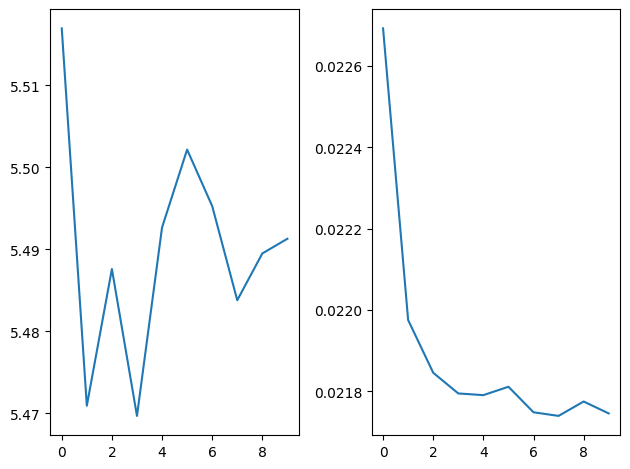

In [281]:
fig, axs=plt.subplots(1,2)
axs[0].plot(valid_losses_mul)
axs[1].plot(train_losses_mul)
plt.tight_layout()

**Definatly we are overfitting this model but tried a lot of ways to optmise it, and also to fit this model was night mare with all dimentations took days to come to this position so glad but cannot perform last thing
i would like to do is to add more projections in decoder if i get time**

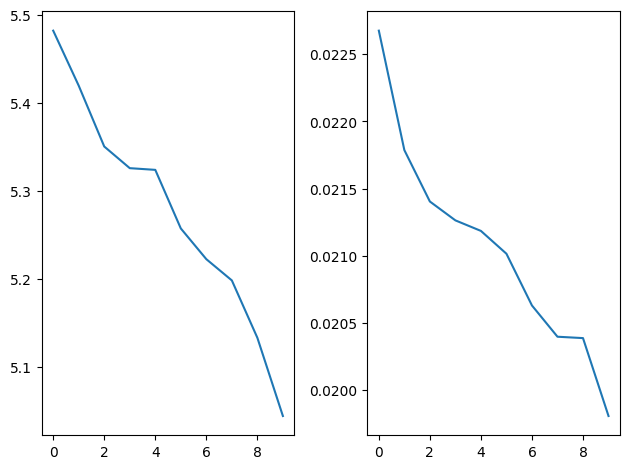

In [355]:
fig, axs=plt.subplots(1,2)
axs[0].plot(valid_losses_mul)
axs[1].plot(train_losses_mul)
plt.tight_layout()

**After adding embedding projections the training can go more longer i suppose**

## Inference

In [671]:
s = input_ids_src[4,:].unsqueeze(0)
t = input_ids_tar[4,:]
model.eval()  

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(281, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(305, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=305, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [357]:
#x, hidden, cell, encoder_state
encoder_state ,hidden, cell = model.encoder(s)
predictions, hidden, cell, attention=model.decoder(t,hidden, cell, encoder_state)

In [406]:
output = predictions  # Shape: [batch_size, seq_len, vocab_size]
attention_weights = attention
# Assuming vocab_size is 299 (as per your example)
index_to_token_src = {i: token for i, token in enumerate(vocab['src'])}
index_to_token = {i: token for i, token in enumerate(vocab['tar'])}
vocab_size = len(vocab['tar'])
output_probs = torch.softmax(output, dim=-1) 
predicted_tokens = output_probs.argmax(dim=-1)  
predicted_sentence = [index_to_token[token.item()] for token in predicted_tokens]  # For batch_size=1, get the first sentence
input_sentebce=[index_to_token_src[token] for token in s.squeeze(0).tolist()]  # For batch_size=1, get the first sentence
print("Predicted Sentence:", " ".join(predicted_sentence))
print("Input Sentence:"," ".join(input_sentebce))

Predicted Sentence: एक्सेर्साइसर प्लग अनुप्रयोग _ अनुप्रयोग अनुप्रयोग अनुप्रयोग रंग
Input Sentence: accerciser accessibility explorer <pad> <pad> <pad> <pad> <pad>


**I dont know if that was the chance but the model gave right translation here**

In [672]:
output = predictions  # Shape: [batch_size, seq_len, vocab_size]
attention_weights = attention
# Assuming vocab_size is 299 (as per your example)
index_to_token_src = {i: token for i, token in enumerate(vocab['src'])}
index_to_token = {i: token for i, token in enumerate(vocab['tar'])}
vocab_size = len(vocab['tar'])
output_probs = torch.softmax(output, dim=-1) 
predicted_tokens = output_probs.argmax(dim=-1)  
predicted_sentence = [index_to_token[token.item()] for token in predicted_tokens]  # For batch_size=1, get the first sentence
input_sentebce=[index_to_token_src[token] for token in s.squeeze(0).tolist()]  # For batch_size=1, get the first sentence
print("Predicted Sentence:", " ".join(predicted_sentence))
print("Input Sentence:"," ".join(input_sentebce))

Predicted Sentence: एक्सेर्साइसर एक्सेर्साइसर एक्सेर्साइसर एक्सेर्साइसर एक्सेर्साइसर एक्सेर्साइसर <pad> <pad>
Input Sentence: a list plugins disabled default <pad> <pad> <pad>


**We can see the repeated words is because the model is not able to explore or learn more complexities need to invesitigate still**

**Due to not taking bigger size as model was taking too long to train we halted early with the required resources and time**

## Atention Map ##

In [438]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    vmin = np.min(attention)
    vmax = np.max(attention)
    cax = ax.matshow(attention, cmap='coolwarm', vmin = vmin, vmax=vmax)
    
    ax.tick_params(labelsize=10)
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    plt.close()

/tmp/ipykernel_4185103/2237828966.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_4185103/2237828966.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
findfont: Font family 'Mangal' not found.
findfont: Font family 'Mangal' not found.
findfont: Font family 'Mangal' not found.
findfont: Font family 'Mangal' not found.
findfont: Font family 'Mangal' not found.
findfont: Font family 'Mangal' not found.
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2319 (\N{DEVANAGARI LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/tljh/user/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanaga

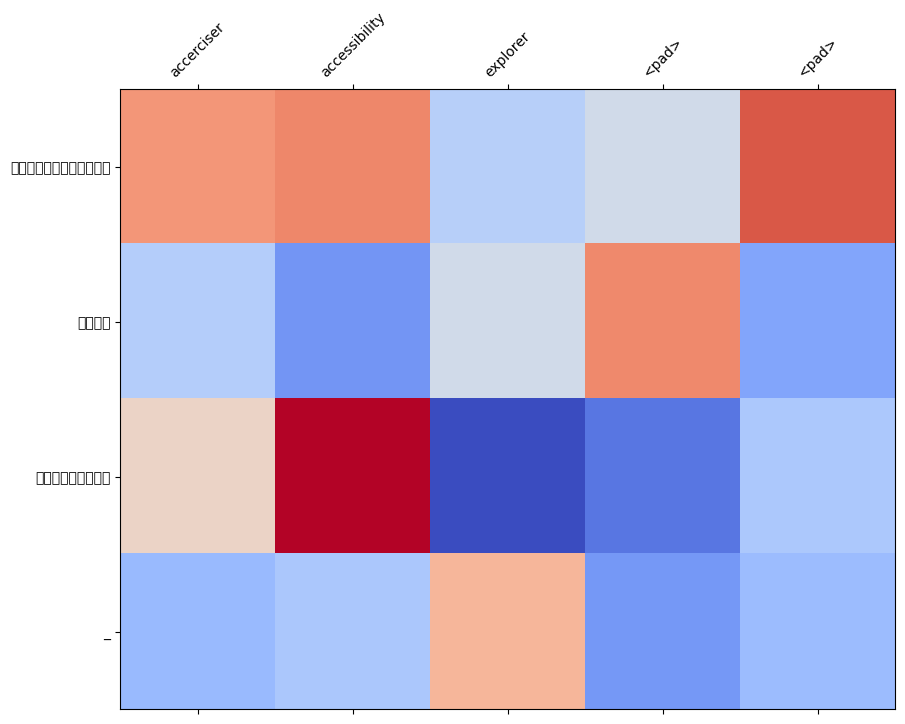

In [439]:
display_attention(input_sentebce, predicted_sentence,attention.squeeze(0).numpy())

**We do not have access to the target langaue so no possibility to see but from above the word we can see the 1 ->1 and 2 -> 3 attention is right , we will add this to our ReadMe**

## Final Thought and Observations

In [1181]:
from IPython.display import display, HTML
import pandas as pd
v=pd.DataFrame(columns =['Attention', 'Traning Loss', 'Training PPL', 'Validation Loss', 'Validation PPL'])
v['Attention'] = ['Additive Attention', 'Multiplicative Attention']
v['Traning Loss'] = ['1.97', '0.020']
v['Training PPL'] = ['7.99', '1.20', ]
v['Validation PPL'] = ['7.63', '115']
v['Validation Loss'] = ['2.049', '5.04']
display(v)

,Attention,Traning Loss,Training PPL,Validation Loss,Validation PPL
0,Additive Attention,1.97,7.99,2.049,7.63
1,Multiplicative Attention,0.020,1.20,5.04,115


**The models are hard to train build the most challanging part is the non monotonisity of models which make it more harder. The key observation here is that additive attention model are faster**
**easier to train than multiplicativite, multiplicative attention design capture more global meaning where as additove more of sementic. Another observation is the score metric here is aith multiplicative is not good**
**shorter trainer where as additive is prone to overfit quicker**